# Using GA to Tune The LQR Drone

In [1]:
!pip install -q deap

In [2]:
from deap import algorithms, base, benchmarks, creator, tools
from deap.benchmarks.tools import diversity, convergence, hypervolume
import array, random, json

In [3]:
from notebook_quick_setup import *

Beginning notebook setup...
	Added /home/jhewers/Repositories/jdrones/src to path
	Imported gymnasium version 0.29.1


pybullet build time: Nov 27 2023 15:36:15


	Imported jdrones version 0.7.3.dev80+g6a8b455.d20240322
	Imported scipy==1.11.4, numpy==1.26.2, pandas==2.1.3
	Imported functools, collections and itertools
	Imported tqdm (standard and trange)
	Imported seaborn==0.13.0, matplotlib==3.8.2
End of notebook setup


In [4]:
def J(obs, u):
    x = np.zeros((obs.shape[0], 20))
    x[:,[0,1,2,10,11,12,7,8,9,13,14,15]] = u
    l1norm = np.linalg.norm(x - obs,axis=0)
    return l1norm @ np.array(
        [0,0,25, # x y z
         0,0,0,0, # Q1 - Q4
         1,1,1, # R P Y
         25,25,0, # vx vy vz
         1,1,1, # P Q R
         0,0,0,0 # P1 - P4
        ]
    )

In [5]:
def simulate(env, u, progress=False):
    dq = collections.deque()
    obs, _ = env.reset()
    
    if progress:
        it = tqdm(u)
    else:
        it = u
    
    for ui in it:
        if np.any(np.isnan(obs)):
            obs[np.isnan(obs)] = np.inf
            dq.append(np.copy(obs))
            break
        
        dq.append(np.copy(obs))
        obs, *_ = env.step(ui)
              
    return States(dq)

In [6]:
def get_drone(Q,R, dt):
    initial_state = State()
    initial_state.pos = (1,1,0.1)
    initial_state.rpy = (0,0,0.3)
    initial_state.prop_omega = np.ones(4)*6
    return gymnasium.make("LQRDroneEnv-v0", Q=Q,R=R, dt=dt, initial_state=initial_state)

In [7]:
def individual_to_Q_R(individual):
    return np.diag(individual[:12]), np.diag(individual[12:])

In [8]:
def cost(individual, dt, u, progress=False):
    Q,R = individual_to_Q_R(individual)
    
    # Check if matrix is singular
    if any(~np.isfinite(np.linalg.cond(f)) for f in (Q,R)):
        return 1e9
    try:
        env = get_drone(Q,R, dt)
    except scipy.linalg.LinAlgError:
        return 1e9
    obs = simulate(env, u, progress=progress)
    return J(obs, u)

In [9]:
T = 5
dt = 1/100
_u  = State()
_u.vel = [2.5,2.5,0]
_u.rpy = [0,0,0]
u = np.repeat(_u.to_x()[None,:],int(T/dt),axis=0)

CXPB, MUTPB = 0.55, 0.05

In [10]:
Q = np.array([1, 1, 1, 50, 50, 10, 100, 100, 10, 1, 1, 1]) * 1e-6
R = np.array([10, 10, 100, 0.001])
benchmark = cost(np.concatenate([Q,R]), dt, u)
benchmark

2086.613390465199

## GA

In [11]:
creator.create("FitnessMin", base.Fitness, weights=(-1,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [12]:
toolbox = base.Toolbox()

In [13]:
import multiprocessing

pool = multiprocessing.Pool(28)
toolbox.register("map", pool.map)

In [14]:
BOUND_LOW = np.array((1e-6,) * 12 + (1,) * 3 + (0,))
BOUND_HIGH = np.array((1e-4,) * 12 + (100,) * 3 + (1e-3,))
SCALE=np.array((1e-5,)*12+(1,)*4)
NDIM = 16

In [15]:
def mutNGaus(indiviudal,scale, N, indpb):
    p = indpb * np.ones(len(indiviudal))
    inds = np.random.choice(np.arange(0,len(indiviudal)),p=p/p.sum(),size=N)

    for i in inds:
        indiviudal[i] = np.clip(indiviudal[i] + np.random.normal(scale=scale[i]),0,np.inf)
    
    return indiviudal

In [16]:
toolbox.register("attr_float", np.random.uniform, BOUND_LOW, BOUND_HIGH, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [17]:
toolbox.register("evaluate", cost,dt=dt,u=u)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", mutNGaus, scale=SCALE,N=1, indpb=1/NDIM)
toolbox.register("select", tools.selTournament, tournsize=3)

In [18]:
def get_pop(n=50):
    pop = toolbox.population(n=n)
    return pop

In [19]:
def get_stats():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    return stats

In [20]:
def get_logbook(stats):
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields
    return logbook

In [21]:
def get_hof(n=5):
     return tools.HallOfFame(n)

In [22]:
stats = get_stats()
pop = get_pop()

if 'logbook' not in globals():
    logbook = get_logbook(stats)
    start_gen = 0
else:
    start_gen = max(logbook, key= lambda v: v['gen'])['gen']+1
    print(f"Old logbook and population found, starting from {start_gen}")
          
if 'hof' in globals():
    for i,ind in enumerate(hof):
        pop[i] = ind
else:
    hof = get_hof()
    
for ind, fit in zip(pop, toolbox.map(toolbox.evaluate, pop)):
    ind.fitness.values = (fit,)
fits = [ind.fitness.values[0] for ind in pop]
    
progress = trange(start_gen,5000+start_gen)
for i in progress:
    hof.update(pop)
    
    compiled = stats.compile(pop)
    logbook.record(gen=i, evals=len(pop), **compiled)    
    progress.set_description(f"({i}) Rel. imp. = {benchmark-hof[0].fitness.values[0]:.2f} | Best: {hof[0].fitness.values[0]:.2f} | Avg: {compiled['avg']:.2f} | Std: {compiled['std']:.2f}")
  
    offspring = toolbox.select(pop, len(pop))
    offspring = list(toolbox.map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = (fit,)
    pop[:] = offspring
    
    fits = [ind.fitness.values[0] for ind in pop]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
stats = pd.DataFrame(logbook)
stats.set_index("gen", inplace=True)

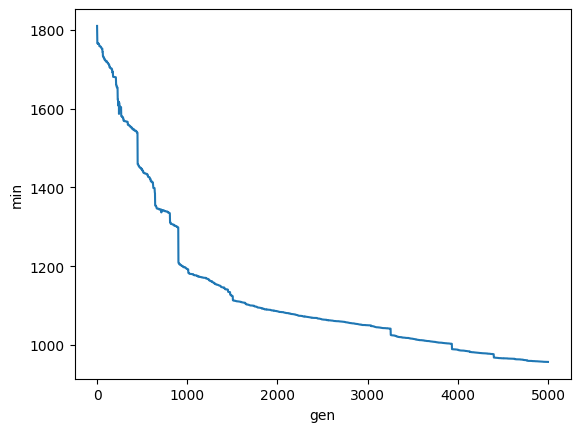

In [24]:
fig, ax = plt.subplots()
sns.lineplot(data=stats,x='gen',y='min',ax=ax)
plt.show()

In [25]:
hof[0]

[4.6176861297742446e-08,
 8.20079210554526e-09,
 0.002015319613213222,
 0.0019725098771573558,
 0.0019729667280019856,
 0.0017448932320868343,
 0.00038948848401190175,
 6.60213968465527e-08,
 0.0013440112213180333,
 0.0002558222985053156,
 7.213974171712665e-08,
 2.2824520808018255e-07,
 0.004613030294333662,
 0.005277238690122938,
 0.003479685903363842,
 0.0004249097075205608]

In [26]:
df = pd.concat(
    [
        simulate(
            get_drone(*individual_to_Q_R(f), dt),
            u,
        ).to_df(tag=t, dt=dt)
        for t, f in [["1st GA", hof[0]], ["Hand Tuned", np.concatenate([Q,R])], ["Random", toolbox.individual()]]
    ]
).reset_index()

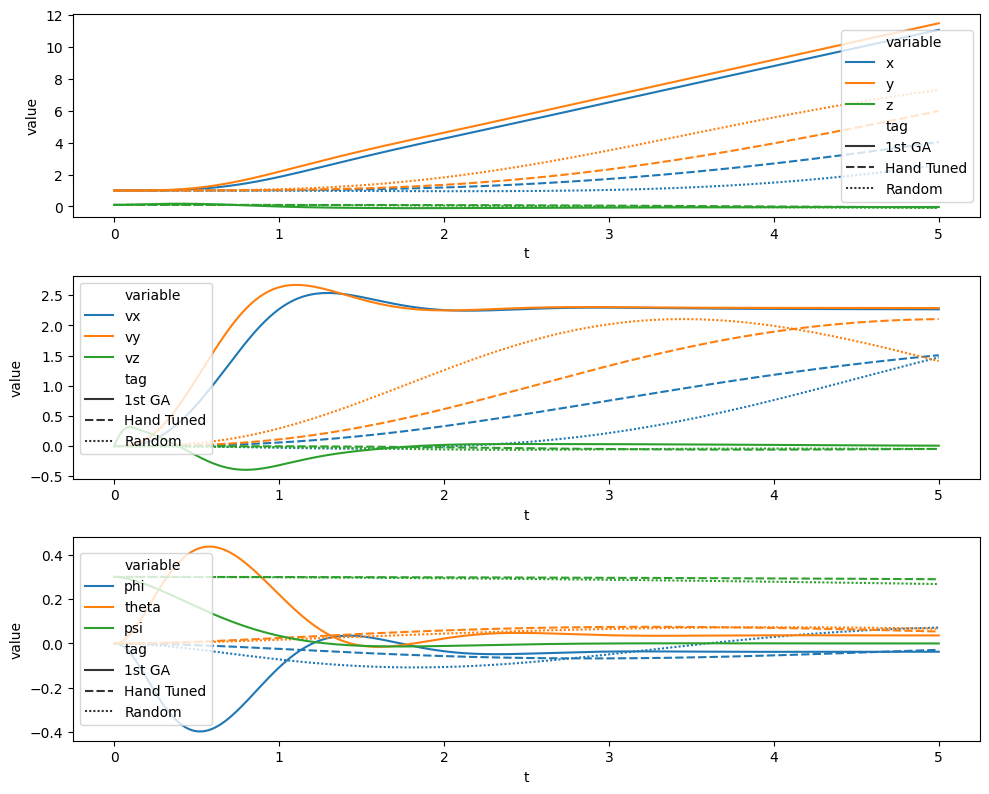

In [27]:
fig, ax = plt.subplots(3, figsize=(10, 8))
ax = ax.flatten()
for i, vars in enumerate(
    ["'x','y','z'","'vx','vy','vz'", "'phi','theta','psi'"]
):
    sns.lineplot(
        data=df.query(f"variable in ({vars})"),
        x="t",
        y="value",
        hue="variable",
        style="tag",
        ax=ax[i],
    )
    ax[i].legend()
fig.tight_layout()
plt.show()